# Лабораторная работа 3
#### ФИО: Кривов Кирилл Иванович 
#### Группа: 8О-308Б

In [11]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from pandas import DataFrame
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

Загрузим обучающую выборку.

In [10]:
FTRAIN = './training.csv'
FTEST = './test.csv'
FLOOKUP = './IdLookupTable.csv'

In [22]:
def load(test=False):
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    print(df.count())
    df = df.dropna()

    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

def load2d(test=False):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [54]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Видно, что только для некоторой части изображений (2140) обозначены все ключевые точки.  
Будем работать только с ними, т.к. не понятно чем заполнять пробелы для оставшихся изображений.  
Также, проведем регуляризацию данных: значение пикселя лежит в пределах [0, 1], координаты - [-1, 1].

In [4]:
import sys
sys.path.append('/home/forlabs/src/lasagne/')
sys.path.append('/home/forlabs/anaconda2/envs/neural_nets/lib/python2.7/site-packages/')
import theano
from lasagne.layers import *
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

/home/forlabs/anaconda2/envs/neural_nets/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [5]:
from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency
from nolearn.lasagne import PrintLayerInfo

layer_info = PrintLayerInfo()

In [6]:
import cPickle as pickle

def net_dump(net_obj, fname):
    with open(fname + '.pickle', 'wb') as f:
        pickle.dump(net_obj, f, -1)
        
def net_load(fname):
    with open(fname + '.pickle', 'rb') as f:
        return pickle.load(f)

Построим простую нейронную сеть с одним скрытым слоем.

In [27]:
net1 = NeuralNet(
    layers=[
        ('input', InputLayer),
        ('hidden', DenseLayer),
        ('output', DenseLayer)],
    
    input_shape=(None, 9216),
    hidden_num_units=100,
    output_nonlinearity=None,
    output_num_units=30,

    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=400,
    verbose=1)

In [13]:
net1.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.24143       0.09571      2.52260  1.02s
      2       0.07210       0.04322      1.66838  0.65s
      3       0.02824       0.01688      1.67309  0.65s
      4       0.01350       0.01166      1.15754  0.64s
      5       0.01071       0.01061      1.00923  0.64s
      6       0.00994       0.01002      0.99242  0.63s
      7       0.00943       0.00959      0.98259  0.66s
      8       0.00903       0.00926      0.97571  0.65s
      9       0.00873       0.00899      0.97100  0.63s
     10       0.00849       0.00877      0.96840  0.63s
     11       0.00829       0.00857      0.96686  0.83s
     12       0.00811       0.00841      0.96536  1.17s
     13       0.00796       0.00825      0.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f78c6c77d10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f78c6c77bd0>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7f78c6c791b8>,
     objective_loss_function=<function squared_error at 0x7f78c71d17d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f78c65bdfc8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f78c65c0050>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     train_split=<nolearn.lasag

In [22]:
net_dump(net1, 'simple_1_hidden_layer')

In [19]:
net1 = net_load('simple_1_hidden_layer')

<module 'matplotlib.pyplot' from '/home/forlabs/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

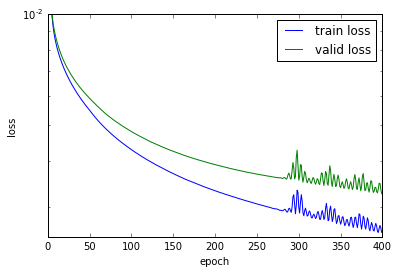

In [20]:
plt.yscale("log")
plt.ylim(2.5e-3, 1e-2)
plot_loss(net1)

Примерно после 280 эпохи начинаются колебания в значениях ошибок. Возможно сеть переобучилась.

Данная сеть на тестовой выбоке дает результат 4.09416.  
На данный момент лучший в соревновании - 1.48735, худший - 52.07722.

В настоящее один из лучших алгоритмов для распознования изображений - сверточная нейронная сеть.  
Добавим сверточные слои.

Проверим на небольшом количестве эпох какие парметры дают лучший результат с приемлемым временем обучения.

Также, для ускорения обучения будем изменять параметры update_learning_rate и update_momentum линейно, в зависимости от номера эпохи.

In [7]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [8]:
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [37]:
net0 = NeuralNet(
    layers=[
        ('input', InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('hidden1', DenseLayer),
        ('output', DenseLayer)],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=8, conv1_filter_size=(2, 2), pool1_pool_size=(2, 2),
    hidden1_num_units=100,
    output_num_units=30, output_nonlinearity=None,

    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999)],

    regression=True,
    max_epochs=50,
    verbose=3)

In [38]:
net0.fit(X, y)

# Neural Network with 1770370 learnable parameters

## Layer information

name     size       total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
-------  -------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input    1x96x96     9216   100.00   100.00   100.00   100.00          96          96         96         96
conv1    8x95x95    72200   100.00   100.00     2.08     2.08           2           2          2          2
pool1    8x47x47    17672   100.00   100.00     2.08     2.08           2           2          2          2
hidden1  100          100   100.00   100.00   100.00   100.00          96          96         96         96
output   30            30   100.00   100.00   100.00   100.00          96          96         96         96

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage 

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3850>,
     check_input=True, conv1_filter_size=(2, 2), conv1_num_filters=8,
     custom_scores=None, hidden1_num_units=100,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f729cce8758>,
     objective_loss_function=<function squared_error at 0x7f729d232de8>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f727b498f10>, <__main__.AdjustVariable object at 0x7f727b4b7ad0>, <nolearn.lasagne.ha

In [39]:
net_dump(net0, 'conv1_8_22_50ep')

In [26]:
net1 = NeuralNet(
    layers=[
        ('input', InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('hidden1', DenseLayer),
        ('output', DenseLayer)],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=8, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    hidden1_num_units=100,
    output_num_units=30, output_nonlinearity=None,

    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999)],

    regression=True,
    max_epochs=50,
    verbose=3)

In [27]:
net1.fit(X, y)

# Neural Network with 1770410 learnable parameters

## Layer information

name     size       total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
-------  -------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input    1x96x96     9216   100.00   100.00   100.00   100.00          96          96         96         96
conv1    8x94x94    70688   100.00   100.00     3.12     3.12           3           3          3          3
pool1    8x47x47    17672   100.00   100.00     3.12     3.12           3           3          3          3
hidden1  100          100   100.00   100.00   100.00   100.00          96          96         96         96
output   30            30   100.00   100.00   100.00   100.00          96          96         96         96

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage 

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3850>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=8,
     custom_scores=None, hidden1_num_units=100,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f729cce8758>,
     objective_loss_function=<function squared_error at 0x7f729d232de8>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f7285679450>, <__main__.AdjustVariable object at 0x7f7284f388d0>, <nolearn.lasagne.ha

In [28]:
net_dump(net1, 'conv1_8_33_50ep')

In [30]:
net2 = NeuralNet(
    layers=[
        ('input', InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('hidden1', DenseLayer),
        ('output', DenseLayer)],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=16, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    hidden1_num_units=100, 
    output_num_units=30, output_nonlinearity=None,

    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999)],

    regression=True,
    max_epochs=50,
    verbose=3)

In [31]:
net2.fit(X, y)

# Neural Network with 3537690 learnable parameters

## Layer information

name     size        total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
-------  --------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input    1x96x96      9216   100.00   100.00   100.00   100.00          96          96         96         96
conv1    16x94x94   141376   100.00   100.00     3.12     3.12           3           3          3          3
pool1    16x47x47    35344   100.00   100.00     3.12     3.12           3           3          3          3
hidden1  100           100   100.00   100.00   100.00   100.00          96          96         96         96
output   30             30   100.00   100.00   100.00   100.00          96          96         96         96

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image co

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f729cce3850>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=16,
     custom_scores=None, hidden1_num_units=100,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f729cce8758>,
     objective_loss_function=<function squared_error at 0x7f729d232de8>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f72847dc990>, <__main__.AdjustVariable object at 0x7f7284a50fd0>, <nolearn.lasagne.h

In [32]:
net_dump(net2, 'conv1_16_33_50ep')

<module 'matplotlib.pyplot' from '/home/forlabs/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

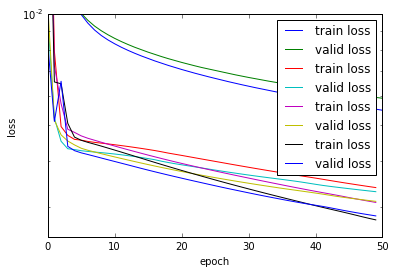

In [42]:
net_simple = net_load('simple_1_hidden_layer')
net0 = net_load('conv1_8_22_50ep')
net1 = net_load('conv1_8_33_50ep')
net2 = net_load('conv1_16_33_50ep')
plt.yscale("log")
plt.xlim(0, 50)
plt.ylim(2.5e-3, 1e-2)
plot_loss(net_simple)
plot_loss(net0)
plot_loss(net1)
plot_loss(net2)

Со сверточным слоем стало заметно лучше.  
Логично также, что увеличение параметров conv1_num_filters и conv1_filter_size увеличивают точность, хотя увеличивают и время (в разы).

Так как мы используем только часть обучающей выборки (всего около трети) сеть обучается не так результативно как могла бы.  
Однако можно зеркально отражать изображения, что искусственно увеличит обучающую выборку.  
В каждой партии будем отражать случайную половину изображений.

In [8]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            yb[indices, ::2] = yb[indices, ::2] * -1
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

Также, в целях оптимизации, введем условие, которое ограничит процесс обучения, если результат не будет улучшаться в течении некоторого количества эпох.

In [9]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

Объединим все в это в одной сети.

In [10]:
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [10]:
final_net = NeuralNet(
    layers=[
        ('input', InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('hidden1', DenseLayer),
        ('output', DenseLayer)],
    
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=8, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    hidden1_num_units=100,
    output_num_units=30, output_nonlinearity=None,

    update=nesterov_momentum,
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=25)],
    
    batch_iterator_train=FlipBatchIterator(batch_size=128),

    regression=True,
    max_epochs=400,
    verbose=2)

In [11]:
final_net.fit(X, y)

# Neural Network with 1770410 learnable parameters

## Layer information

name     size       total    cap.Y    cap.X    cov.Y    cov.X
-------  -------  -------  -------  -------  -------  -------
input    1x96x96     9216   100.00   100.00   100.00   100.00
conv1    8x94x94    70688   100.00   100.00     3.12     3.12
pool1    8x47x47    17672   100.00   100.00     3.12     3.12
hidden1  100          100   100.00   100.00   100.00   100.00
output   30            30   100.00   100.00   100.00   100.00

Explanation
    X, Y:    image dimensions
    cap.:    learning capacity
    cov.:    coverage of image
    magenta: capacity too low (<1/6)
    cyan:    image coverage too high (>100%)
    red:     capacity too low and coverage too high


  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.03914       0.00824      4.74756  7.44s
      2       0.00691       0.02318      0.29796  7.14s
      3       0.01088       0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8b549949d0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f8b547d4050>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=8,
     custom_scores=None, hidden1_num_units=100,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7f8b54997de8>,
     objective_loss_function=<function squared_error at 0x7f8b555b5500>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f8b54994e50>, <__main__.AdjustVariable object at 0x7f8b547e6f90>, <__main__.EarlyStopping ob

In [12]:
net_dump(final_net, 'final_net')

<module 'matplotlib.pyplot' from '/home/forlabs/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

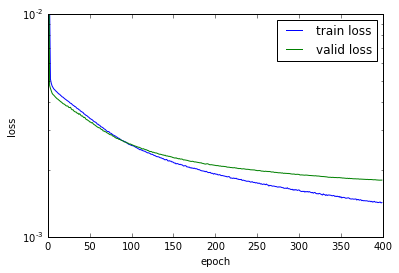

In [17]:
plt.yscale("log")
plt.ylim(1e-3, 1e-2)
plot_loss(final_net)

In [14]:
final_net = net_load('final_net')

In [19]:
from datetime import datetime


def predict(fname, linearize=True):
    nn = net_load(fname)

    columns = ['left_eye_center', 'right_eye_center', 
            'left_eye_inner_corner', 'left_eye_outer_corner', 
            'right_eye_inner_corner', 'right_eye_outer_corner', 
            'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 
            'right_eyebrow_inner_end', 'right_eyebrow_outer_end', 
            'nose_tip', 
            'mouth_left_corner', 'mouth_right_corner', 
            'mouth_center_top_lip', 'mouth_center_bottom_lip']

    columns = reduce(lambda a, x: a + [x + '_x', x + '_y'], columns, [])

    if linearize:
        X, _ = load(test=True)
    else:
        X, _ = load2d(test=True)

    y_pred = nn.predict(X) * 48 + 48
    y_pred = y_pred.clip(0, 96)
    df = DataFrame(y_pred, columns=columns)

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    for index, row in lookup_table.iterrows():
        values.append((row['RowId'], 
                       df.ix[row.ImageId - 1][row.FeatureName]))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = 'submission-{}-{}.csv'.format(fname, now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))

In [23]:
predict('final_net', False)

ImageId    1783
Image      1783
dtype: int64
Wrote submission-final_net-2016-06-25T14-42-40.730885.csv


Данное решение показало результат 3.53414, что в сравнении с 4.09416 выглядит гораздо лучше.

In [26]:
predict('conv1_16_33_50ep', False)

ImageId    1783
Image      1783
dtype: int64
Wrote submission-conv1_16_33_50ep-2016-06-25T14-48-51.729614.csv


Сеть с удвоенным количеством фильтров (num_filters в сверточном слое, 16 против 8) и количеством эпох 50 показывает результат 3.88560, что очень близко к 3.53414 (400 эпох, num_filters=8), однако тренируется всего ~13 минут (одна эпоха ~15.5c) против ~50 минут (одна эпоха ~7.5c).